In [274]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


In [275]:
red = pd.read_csv("winequality-red.csv")

def define_quality_labels(v):
  if v <= 5:
    return 0
  if v <= 7:
    return 1
  return 2

red.columns = red.columns.str.replace(" ", "_")

In [276]:
red['quality_label'] = red['quality'].apply(define_quality_labels)

red['quality_label'] = pd.Categorical(red['quality_label'], categories=[0, 1, 2])

dfml_red = red.copy()
# dfml_red.info()

dfml_red.drop(['quality', 'density'], axis=1, inplace=True)
dfml_red


,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,pH,sulphates,alcohol,quality_label
0,7.4,0.700,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,0
1,7.8,0.880,0.00,2.6,0.098,25.0,67.0,3.20,0.68,9.8,0
2,7.8,0.760,0.04,2.3,0.092,15.0,54.0,3.26,0.65,9.8,0
3,11.2,0.280,0.56,1.9,0.075,17.0,60.0,3.16,0.58,9.8,1
4,7.4,0.700,0.00,1.9,0.076,11.0,34.0,3.51,0.56,9.4,0
...,...,...,...,...,...,...,...,...,...,...,...
1594,6.2,0.600,0.08,2.0,0.090,32.0,44.0,3.45,0.58,10.5,0
1595,5.9,0.550,0.10,2.2,0.062,39.0,51.0,3.52,0.76,11.2,1
1596,6.3,0.510,0.13,2.3,0.076,29.0,40.0,3.42,0.75,11.0,1
1597,5.9,0.645,0.12,2.0,0.075,32.0,44.0,3.57,0.71,10.2,0


# Red Wine Logistic Regression

In [277]:
y = dfml_red['quality_label']
X = dfml_red.drop(['quality_label'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.333, random_state=42)

# X_train.groupby(['quality_label'])['quality_label'].count() #don't drop quality label in order to see this 
# X_test.groupby(['quality_label'])['quality_label'].count()
# df_SO2_outliers_removed.groupby(['quality_label'])['quality_label'].count()



In [278]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

In [279]:
# LogisticRegression model
LR_model = LogisticRegression(random_state=42, max_iter=10000)

# fit model
LR_model.fit(X_train_standard, y_train)

LogisticRegression(max_iter=10000, random_state=42)

In [280]:
preds = LR_model.predict(X_test_standard)

acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print("accuracy: ", acc)
print("confusion_matrix: \n", cm)
print(classification_report(y_test, preds, zero_division=True))

accuracy:  0.7279549718574109
confusion_matrix: 
 [[179  61   0]
 [ 77 209   0]
 [  0   7   0]]
              precision    recall  f1-score   support

           0       0.70      0.75      0.72       240
           1       0.75      0.73      0.74       286
           2       1.00      0.00      0.00         7

    accuracy                           0.73       533
   macro avg       0.82      0.49      0.49       533
weighted avg       0.73      0.73      0.72       533



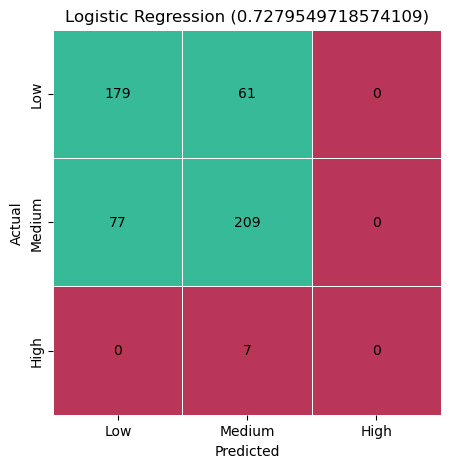

In [281]:
plt.figure(figsize=(5,5))

cm_df = pd.DataFrame(cm, index=["Low","Medium", "High"], columns=["Low","Medium", "High"])

cmap = sns.color_palette(["#BA3658", "#36BA98", "#BA3658", "#36BA98"])
sns.heatmap(cm_df, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=.5, linecolor='white', annot_kws={"color": "black"})

plt.title('Logistic Regression (' + str(acc) + ')')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# Red Wine Random Forest

In [ ]:
# Random Forest Classifier model
# RF_clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced_subsample')
RF_clf = RandomForestClassifier(random_state=42, class_weight='balanced_subsample')

param_grid = { 
    'n_estimators': np.arange(25, 525, 25),
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': np.arange(2, 9),
    'criterion': ['gini', 'entropy']
}

grid = GridSearchCV(estimator=RF_clf, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("The best parameters are %s with a score of %0.2f"
      % (grid.best_params_, grid.best_score_))

In [283]:
# fit model
RF_clf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced_subsample', random_state=42)

In [284]:
score = RF_clf.score(X_test, y_test)

# predictions
preds = RF_clf.predict(X_test)

# accuracy
acc = accuracy_score(y_test, preds)
cm = confusion_matrix(y_test, preds)

print("accuracy score:", acc)
print("confusion_matrix: \n", cm)
print("classification report: \n", classification_report(y_test, preds))
print("score:", score)


accuracy score: 0.8030018761726079
confusion_matrix: 
 [[186  54   0]
 [ 45 241   0]
 [  0   6   1]]
classification report: 
               precision    recall  f1-score   support

           0       0.81      0.78      0.79       240
           1       0.80      0.84      0.82       286
           2       1.00      0.14      0.25         7

    accuracy                           0.80       533
   macro avg       0.87      0.59      0.62       533
weighted avg       0.81      0.80      0.80       533

score: 0.8030018761726079


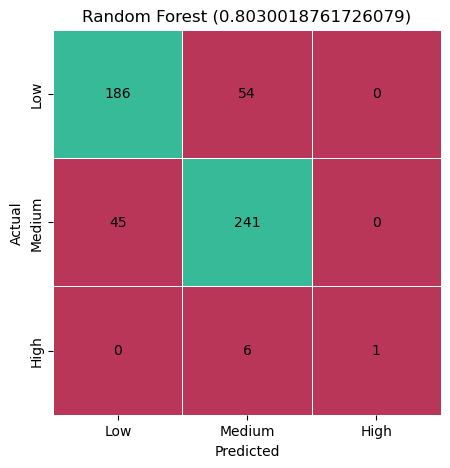

In [285]:
from matplotlib.lines import Line2D

# plt.figure(figsize=(5,5))
fig, ax = plt.subplots(figsize=(5,5))

cm_df = pd.DataFrame(cm, index=["Low","Medium", "High"], columns=["Low","Medium", "High"])

cmap = sns.color_palette(["#BA3658", "#36BA98", "#BA3658", "#36BA98"])
sns.heatmap(cm_df, annot=True, fmt='d', cmap=cmap, cbar=False, linewidths=.5, linecolor='white', annot_kws={"color": "black"})

plt.title('Random Forest (' + str(acc) + ')')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# my_colors = ["#BA3658", "#36BA98"]
# unavail_color = 'lightgray'
# handles = [
#   Line2D(
#     [], 
#     [], 
#     lw=10, 
#     color=color, 
#     label=label) 
#     for color, label in zip(my_colors + [unavail_color],
#     ['Incorrectly Predicted', 'Correctly Predicted'])]

# ax.legend(handles=handles, bbox_to_anchor=(0.5, -0.02), loc='upper center')

# ax.xaxis.set_label_position('top')
# ax.xaxis.tick_top()

# img  = low: 236, medium: 287, high: 5
# code = low: 141, medium: 174, high: 5 (split 0.2)
# code = low: 213, medium: 261, high: 6 (split 0.3)
# code = low: 238, medium: 283, high: 7 (split 0.33)